In [1]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'


# Initialize parameters
Date = "2010-01-01"
End = None
# API endpoints 
# EIA endpoints


 
urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'   
totalurl = 'https://api.eia.gov/v2/total-energy/data/'

# Parameters

WTI = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RWTC",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

Brent = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RBRTE",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

export = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[msn][0]": "COEXPUS",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}



response2 = requests.get(urlPrice, params=WTI)
data2 = response2.json()
df6 = pd.DataFrame(data2['response']['data'])
df6 = df6[['period', 'value']]
df6.rename(columns={'value': 'WTI'}, inplace=True)
df6.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(urlPrice, params=Brent)
data2 = response2.json()
df8 = pd.DataFrame(data2['response']['data'])
df8 = df8[['period', 'value']]
df8.rename(columns={'value': 'Brent'}, inplace=True)
df8.rename(columns={'period': 'ds'}, inplace=True)


response2 = requests.get(totalurl, params=export)
data2 = response2.json()
df1 = pd.DataFrame(data2['response']['data'])
df1 = df1[['period', 'value']]
df1.rename(columns={'value': 'Exports'}, inplace=True)
df1.rename(columns={'period': 'ds'}, inplace=True)


for df in [df1, df6, df8]:
    df['ds'] = pd.to_datetime(df['ds']).dt.to_period('M').dt.to_timestamp()
df_merged = df1
df_merged = pd.merge(df_merged, df8, on='ds', how='outer')
df_merged = pd.merge(df_merged, df6, on='ds', how='outer')




print(df_merged.tail(20))

df_merged.to_pickle("Exports.pkl")

            ds   Exports  Brent    WTI
166 2023-11-01  3928.945  82.94  77.69
167 2023-12-01  4621.713  77.63   71.9
168 2024-01-01  4049.093  80.12  74.15
169 2024-02-01  4660.393  83.48  77.25
170 2024-03-01   4311.54  85.41  81.28
171 2024-04-01   4100.34  89.94  85.35
172 2024-05-01  4116.173  81.75  80.02
173 2024-06-01  4231.014  82.25  79.77
174 2024-07-01  4192.821  85.15   81.8
175 2024-08-01  3907.376  80.36  76.68
176 2024-09-01  3721.567  74.02  70.24
177 2024-10-01  3871.235  75.63  71.99
178 2024-11-01  4334.207  74.35  69.95
179 2024-12-01  3850.349  73.86  70.12
180 2025-01-01  3930.922  79.27  75.74
181 2025-02-01  4294.129  75.44  71.53
182 2025-03-01   4043.42  72.73  68.24
183 2025-04-01  4105.267  68.13  63.54
184 2025-05-01   3747.29  64.45  62.17
185 2025-06-01       NaN  71.44  68.17


In [3]:
# Approximate current month pricing data
df = pd.read_pickle("Exports.pkl")
df['ds'] = pd.to_datetime(df['ds'])

# === Step 1: Get current month start ===
last_reported_month = df['ds'].max()
next_month_start = last_reported_month + relativedelta(months=1)


# === Step 2: Check if row exists for current month ===
if next_month_start not in df['ds'].values:
    
    # === Step 3: Get 30-day average prices from yfinance ===
    today = datetime.today()
    start_date = today - timedelta(days=30)

    wti = yf.download("CL=F", start=start_date, end=today)['Close'].dropna()
    wti_avg = wti.mean().item()

    brent = yf.download('BZ=F', start=start_date, end=today)['Close'].dropna()
    brent_avg = brent.mean().item()

    # === Step 4: Create new row ===
    new_row = {
        'ds': next_month_start,
        'WTI': wti_avg,
        'Brent': brent_avg,
        # Fill other columns with NaN
        'Exports': None,
    }

    # === Step 5: Append to DataFrame ===
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
 

last_reported_month = df['ds'].max()
next_month_start = last_reported_month + relativedelta(months=1)
new_row = {
    'ds': next_month_start,
    'WTI': None,
    'Brent': None,
    # Fill other columns with NaN
    'Exports': None,
}


df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.to_pickle("Exports1.pkl")

print(df.tail(20))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

            ds   Exports      Brent        WTI
168 2024-01-01  4049.093      80.12      74.15
169 2024-02-01  4660.393      83.48      77.25
170 2024-03-01   4311.54      85.41      81.28
171 2024-04-01   4100.34      89.94      85.35
172 2024-05-01  4116.173      81.75      80.02
173 2024-06-01  4231.014      82.25      79.77
174 2024-07-01  4192.821      85.15       81.8
175 2024-08-01  3907.376      80.36      76.68
176 2024-09-01  3721.567      74.02      70.24
177 2024-10-01  3871.235      75.63      71.99
178 2024-11-01  4334.207      74.35      69.95
179 2024-12-01  3850.349      73.86      70.12
180 2025-01-01  3930.922      79.27      75.74
181 2025-02-01  4294.129      75.44      71.53
182 2025-03-01   4043.42      72.73      68.24
183 2025-04-01  4105.267      68.13      63.54
184 2025-05-01   3747.29      64.45      62.17
185 2025-06-01       NaN      71.44      68.17
186 2025-07-01      None  70.264738  68.232104
187 2025-08-01      None       None       None



=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      243.04
RMSE (Root Mean Squared Error): 338.63
MAPE (Mean Absolute % Error):   5.71%


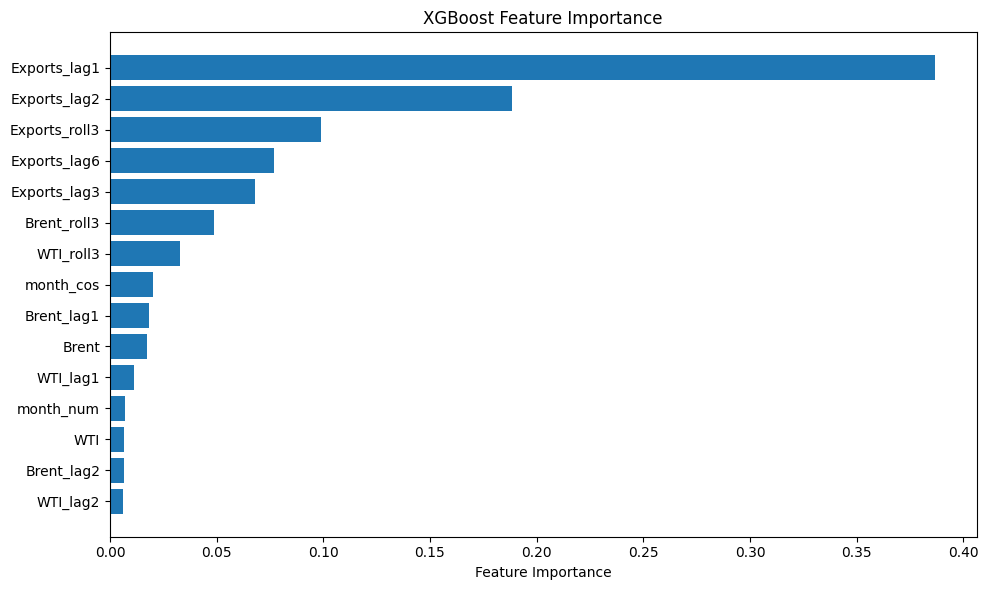


=== Final df with historical + forecasted values ===
        ds     Exports
2025-01-01 3930.922000
2025-02-01 4294.129000
2025-03-01 4043.420000
2025-04-01 4105.267000
2025-05-01 3747.290000
2025-06-01 3601.794922
2025-07-01 3661.291992
2025-08-01 3767.950195

=== Best Parameters Found ===
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}


: 

In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'Exports'
EXOG_COLS = ['Brent', 'WTI']
df = pd.read_pickle("Exports1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=100,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.6,
    colsample_bytree=1,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

#

importances = model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[sorted_idx][:top_n][::-1])
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
df.to_pickle("ExportD.pkl")
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))


#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""